In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
data = pd.read_csv('/content/drive/MyDrive/Colab_DL_docs/Capstone2/TATAMOTORS.csv')

In [39]:
data.shape

(1233, 7)

In [40]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-09,256.649994,260.399994,255.500000,257.850006,257.048859,7777719
1,2018-08-10,257.250000,258.649994,249.550003,250.100006,249.322937,14606037
2,2018-08-13,249.250000,249.699997,243.100006,248.699997,247.927277,13877900
3,2018-08-14,248.600006,249.850006,247.199997,248.800003,248.026978,9171033
4,2018-08-16,245.800003,252.800003,245.250000,251.300003,250.519211,14148347
...,...,...,...,...,...,...,...
1228,2023-08-02,644.000000,644.299988,616.450012,622.650024,622.650024,15762687
1229,2023-08-03,623.000000,626.450012,614.150024,618.950012,618.950012,11458920
1230,2023-08-04,624.849976,625.000000,613.299988,615.000000,615.000000,11806739
1231,2023-08-07,619.000000,619.000000,608.500000,609.500000,609.500000,9893466


In [41]:
data = data[['Date','Close']]

In [42]:
real_dates=data['Date']

In [43]:
data['date_fix'] = pd.date_range(end ='8/8/2023', freq ='D', periods =len(data))

In [44]:
data.drop(columns = ['Date'],inplace=True)

In [45]:
#data.set_index('date_fix',inplace=True)

In [46]:
data

,Close,date_fix
0,257.850006,2020-03-24
1,250.100006,2020-03-25
2,248.699997,2020-03-26
3,248.800003,2020-03-27
4,251.300003,2020-03-28
...,...,...
1228,622.650024,2023-08-04
1229,618.950012,2023-08-05
1230,615.000000,2023-08-06
1231,609.500000,2023-08-07


In [47]:
import matplotlib.pyplot as plt

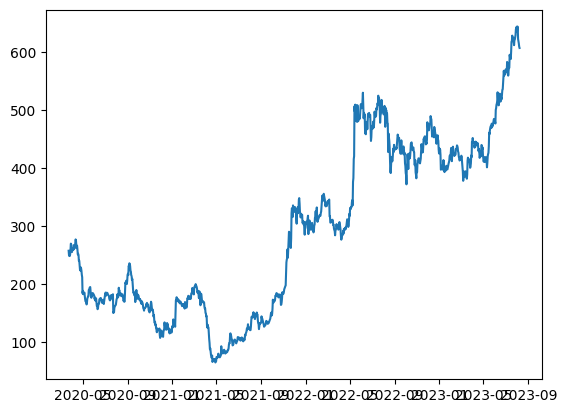

In [48]:
plt.plot(data['date_fix'], data['Close'])

In [49]:
import torch
import torch.nn as nn

In [50]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

#Converting in Sequential pattern for the time series analysis

In [51]:
data.rename(columns = {'Close':'close'},inplace=True)

In [52]:
data

,close,date_fix
0,257.850006,2020-03-24
1,250.100006,2020-03-25
2,248.699997,2020-03-26
3,248.800003,2020-03-27
4,251.300003,2020-03-28
...,...,...
1228,622.650024,2023-08-04
1229,618.950012,2023-08-05
1230,615.000000,2023-08-06
1231,609.500000,2023-08-07


In [53]:
from copy import deepcopy as dc

def prep_df_fr_lstm(df,n_steps):
  df= dc(df)
  df.set_index('date_fix', inplace=True)

  for i in range(1,n_steps+1):
    df[f'close(t-{i})'] = df['close'].shift(i)

  df.dropna(inplace=True)

  return df

In [54]:
lookback=7
shifted_df = prep_df_fr_lstm(data,lookback)

In [55]:
shifted_df.columns

Index(['close', 'close(t-1)', 'close(t-2)', 'close(t-3)', 'close(t-4)',
       'close(t-5)', 'close(t-6)', 'close(t-7)'],
      dtype='object')

###### Now we will use shifted_df columns ['close(t-1)', 'close(t-2)', 'close(t-3)', 'close(t-4)','close(t-5)', 'close(t-6)', 'close(t-7)'] to predict the value of ['close(t)'].

In [56]:
dates=shifted_df.index

In [57]:
#converting pandas dataframe to numpy array
shifted_df_to_np=shifted_df.to_numpy()

In [58]:
shifted_df_to_np

array([[268.799988, 270.100006, 258.25    , ..., 248.699997, 250.100006,
        257.850006],
       [256.899994, 268.799988, 270.100006, ..., 248.800003, 248.699997,
        250.100006],
       [255.5     , 256.899994, 268.799988, ..., 251.300003, 248.800003,
        248.699997],
       ...,
       [615.      , 618.950012, 622.650024, ..., 635.299988, 643.700012,
        641.099976],
       [609.5     , 615.      , 618.950012, ..., 644.299988, 635.299988,
        643.700012],
       [607.299988, 609.5     , 615.      , ..., 643.650024, 644.299988,
        635.299988]])

In [59]:
#Z Normalising

#from sklearn.preprocessing import MinMaxScaler as mms

#shifted_df_norm = mms(feature_range=(-1,1)).fit_transform(shifted_df_to_np)

In [60]:
#shifted_df_norm

In [61]:
#X = all rows except first column
x = shifted_df_to_np[:,1:]


#Y = first column only
y = shifted_df_to_np[:,0]

In [62]:
dates.shape, x.shape, y.shape

((1226,), (1226, 7), (1226,))

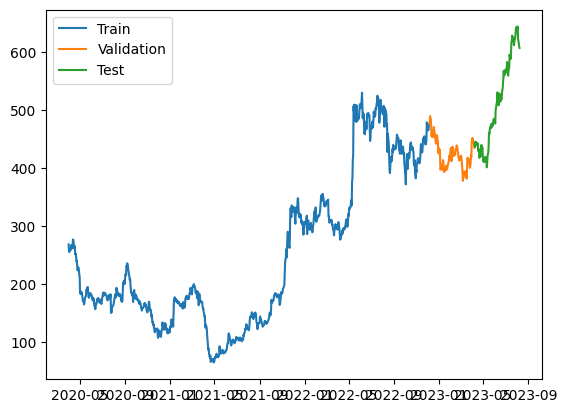

In [63]:
q80 = int(len(dates) * 0.8)
q90 = int(len(dates) * 0.9)

dates_train,x_train,y_train = dates[:q80], x[:q80],y[:q80]

dates_val,x_val,y_val    = dates[q80:q90], x[q80:q90], y[q80:q90]
dates_test,x_test,y_test = dates[q90:],x[q90:], y[q90:]


plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(['Train','Validation','Test'])

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [65]:
model = Sequential([layers.Input((7,1)),
                    layers.LSTM(100,return_sequences = True),
                    layers.LSTM(100,return_sequences = True),
                    layers.LSTM(64),

                    layers.Dense(32,activation = 'relu'),
                    layers.Dense(32,activation = 'relu'),
                    layers.Dense(1)])

In [66]:
model.compile(loss = 'mse',optimizer = Adam(learning_rate=0.001),metrics = ['mean_squared_error'])

In [67]:
model.fit(x_train,y_train, validation_data =(x_val,y_val),epochs= 1000)

Epoch 1/1000
31/31 [==============================] - 13s 55ms/step - loss: 76523.7891 - mean_squared_error: 76523.7891 - val_loss: 171777.2031 - val_mean_squared_error: 171777.2031
Epoch 2/1000
31/31 [==============================] - 0s 9ms/step - loss: 69716.5938 - mean_squared_error: 69716.5938 - val_loss: 156194.0781 - val_mean_squared_error: 156194.0781
Epoch 3/1000
31/31 [==============================] - 0s 9ms/step - loss: 58435.2617 - mean_squared_error: 58435.2617 - val_loss: 129908.7344 - val_mean_squared_error: 129908.7344
Epoch 4/1000
31/31 [==============================] - 0s 9ms/step - loss: 42529.6484 - mean_squared_error: 42529.6484 - val_loss: 94514.0625 - val_mean_squared_error: 94514.0625
Epoch 5/1000
31/31 [==============================] - 0s 9ms/step - loss: 26982.0508 - mean_squared_error: 26982.0508 - val_loss: 59231.5547 - val_mean_squared_error: 59231.5547
Epoch 6/1000
31/31 [==============================] - 0s 9ms/step - loss: 18605.2168 - mean_squared_er

31/31 [==============================] - 0s 3ms/step


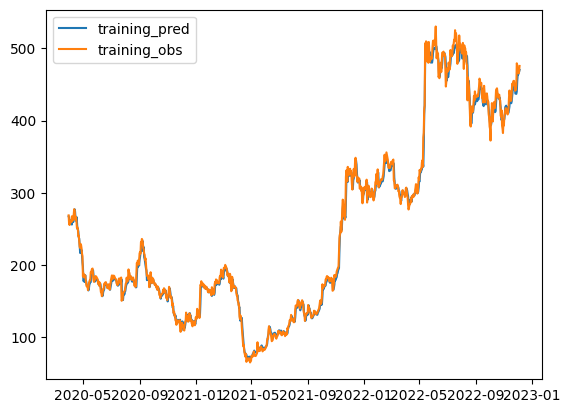

In [72]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['training_pred','training_obs'])

4/4 [==============================] - 0s 4ms/step


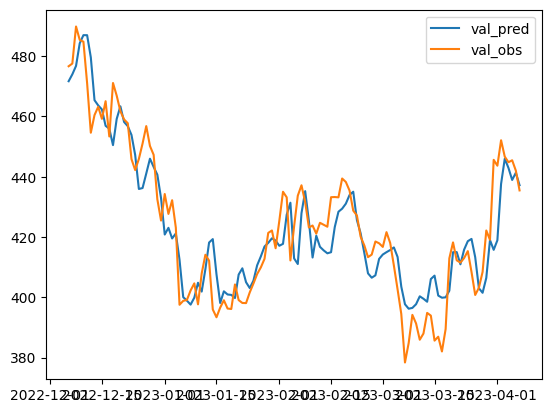

In [73]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val,val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['val_pred','val_obs'])

4/4 [==============================] - 0s 5ms/step


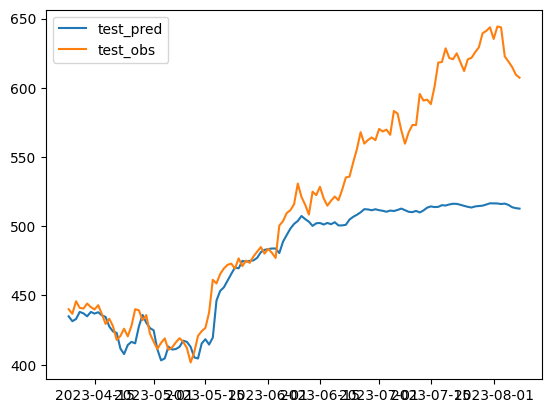

In [74]:
test_predictions = model.predict(x_test).flatten()

plt.plot(dates_test,test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['test_pred','test_obs'])

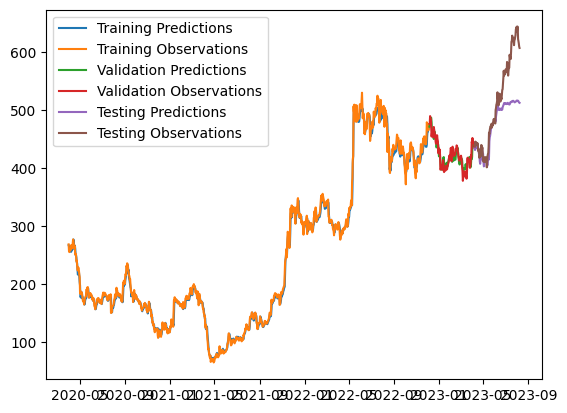

In [75]:
plt.plot (dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot (dates_val, val_predictions)
plt.plot (dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend (['Training Predictions','Training Observations','Validation Predictions','Validation Observations','Testing Predictions','Testing Observations'])